In [1]:
# Libraries
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics         import mean_squared_error
from sklearn.tree            import DecisionTreeRegressor
from sklearn.preprocessing   import StandardScaler
from sklearn.utils           import resample
from sklearn.ensemble        import AdaBoostRegressor

warnings.filterwarnings('ignore')

In [2]:
# local file paths

dir_name = 'selezione'
region_names = np.array(['A', 'B', 'C'])

fp_Xtrain = []
fp_Xval   = []
fp_Xtest  = []
fp_ytrain = []
fp_yval   = []
fp_ytest  = []

for i in range(3):
    fp_Xtrain.append(dir_name + f'/X_train{region_names[i]}.csv')
    fp_Xval  .append(dir_name + f'/X_val{  region_names[i]}.csv')
    fp_Xtest .append(dir_name + f'/X_test{ region_names[i]}.csv')
    fp_ytrain.append(dir_name + f'/y_train{region_names[i]}.csv')
    fp_yval  .append(dir_name + f'/y_val{  region_names[i]}.csv')
    fp_ytest .append(dir_name + f'/y_test{ region_names[i]}.csv')

In [3]:
# Lettura dei dati

X_train = []
X_val   = []
X_test  = []
y_train = []
y_val   = []
y_test  = []

for i in range(3):
    X_train.append(pd.read_csv(fp_Xtrain[i], low_memory=False))
    X_val  .append(pd.read_csv(fp_Xval  [i], low_memory=False))        
    X_test .append(pd.read_csv(fp_Xtest [i], low_memory=False))
    y_train.append(pd.read_csv(fp_ytrain[i], low_memory=False))
    y_val  .append(pd.read_csv(fp_yval  [i], low_memory=False))        
    y_test .append(pd.read_csv(fp_ytest [i], low_memory=False))
    
X_train = np.array(X_train, dtype=object)
X_val   = np.array(X_val,   dtype=object)
X_test  = np.array(X_test,  dtype=object)
y_train = np.array(y_train, dtype=object)
y_val   = np.array(y_val,   dtype=object)
y_test  = np.array(y_test,  dtype=object)

In [4]:
def dimensionality(y=False):
    for i in range(3):
        print(f'X_train{region_names[i]}: {X_train[i].shape}')
        print(f'X_val{region_names[i]}:   {X_val  [i].shape}')
        print(f'X_test{region_names[i]}:  {X_test [i].shape}')
        if y:
            print(f'y_train{region_names[i]}: {y_train[i].shape}')
            print(f'y_val{region_names[i]}:   {y_val  [i].shape}')
            print(f'y_test{region_names[i]}:  {y_test [i].shape}')
        print()

In [5]:
dimensionality(y=True)

X_trainA: (26819, 41)
X_valA:   (9006, 41)
X_testA:  (9085, 41)
y_trainA: (26819, 1)
y_valA:   (9006, 1)
y_testA:  (9085, 1)

X_trainB: (8119, 34)
X_valB:   (2658, 34)
X_testB:  (2606, 34)
y_trainB: (8119, 1)
y_valB:   (2658, 1)
y_testB:  (2606, 1)

X_trainC: (64771, 48)
X_valC:   (21908, 48)
X_testC:  (21876, 48)
y_trainC: (64771, 1)
y_valC:   (21908, 1)
y_testC:  (21876, 1)



In [6]:
# GLOBALS

region_ids   = np.array(['1286', '2061', '3101'])

C_PERC = 2/5
C_IND  = 2

#SUB_PERC = [1/1000, 1/100, 1/1000] # circa 100, per testing, 2 minuti per regione
SUB_PERC = [   1/3,     1,    1/3] # circa 8000, mezz'ora per regione
#SUB_PERC = [     1,     1,      1] # dataset completo, tre ore per regione

DTR_START = 10
DTR_END   = 200
DTR_STEP  = 10

BOOST_START =  20
BOOST_END   = 300
BOOST_STEP  =  20
BOOST_NTEST =  20
#BOOST_SAMPLE_PERC = 1/3 # 0.33
BOOST_SAMPLE_PERC = 2/3 # 0.67

Per limiti tecnici di memoria, la gestione del dataset C risulta complicata e incorre spesso in errori a run-time di cateoria __MemoryError__

Le macchine su cui sono eseguiti i notebook supportano operazioni su circa 30000 righe, quindi uso i 2/5 del dataset originale per la Regione C

In [7]:
perc = C_PERC
ind  = C_IND
for X, y in zip([X_train, X_val, X_test], [y_train, y_val, y_test]):
    X[ind], y[ind] = resample(
        X[ind], y[ind],
        n_samples = int(perc * len(X[2]))
    )

In [8]:
dimensionality(y=True)

X_trainA: (26819, 41)
X_valA:   (9006, 41)
X_testA:  (9085, 41)
y_trainA: (26819, 1)
y_valA:   (9006, 1)
y_testA:  (9085, 1)

X_trainB: (8119, 34)
X_valB:   (2658, 34)
X_testB:  (2606, 34)
y_trainB: (8119, 1)
y_valB:   (2658, 1)
y_testB:  (2606, 1)

X_trainC: (25908, 48)
X_valC:   (8763, 48)
X_testC:  (8750, 48)
y_trainC: (25908, 1)
y_valC:   (8763, 1)
y_testC:  (8750, 1)



# Insieme di costruzione del modello

In [9]:
sub_perc = SUB_PERC

In [10]:
for i in range(3):
    print(int(len(X_train[i])*sub_perc[i]))
    print(int(len(X_val  [i])*sub_perc[i]))
    print()

8939
3002

8119
2658

8636
2921



In [11]:
X_train_sub = []
y_train_sub = []
X_val_sub = []
y_val_sub = []

In [12]:
for i in range(3):
    Xt_sub, yt_sub = resample(X_train[i], y_train[i], n_samples = int(sub_perc[i]*len(X_train[i])))
    Xv_sub, yv_sub = resample(X_val  [i], y_val  [i], n_samples = int(sub_perc[i]*len(X_val[i])))
    X_train_sub.append(Xt_sub)
    y_train_sub.append(yt_sub)
    X_val_sub  .append(Xv_sub)
    y_val_sub  .append(yv_sub)

In [13]:
def dimensionality_sub(y=False):
    for i in range(3):
        print(f'X_train_sub{region_names[i]}: {X_train_sub[i].shape}')
        print(f'X_val_sub{region_names[i]}:   {X_val_sub  [i].shape}')
        if y:
            print(f'y_train_sub{region_names[i]}: {y_train_sub[i].shape}')
            print(f'y_val_sub{region_names[i]}:   {y_val_sub  [i].shape}')
        print()

In [14]:
dimensionality_sub(y=True)

X_train_subA: (8939, 41)
X_val_subA:   (3002, 41)
y_train_subA: (8939, 1)
y_val_subA:   (3002, 1)

X_train_subB: (8119, 34)
X_val_subB:   (2658, 34)
y_train_subB: (8119, 1)
y_val_subB:   (2658, 1)

X_train_subC: (8636, 48)
X_val_subC:   (2921, 48)
y_train_subC: (8636, 1)
y_val_subC:   (2921, 1)



# Costruzione DecisionTreeRegressor #

In [15]:
plt.rcParams.update({'font.size': 35})

In [16]:
def get_bias_var_mse(X, y, model):
        y_pred = model.predict(X)
        return {
            'bias': ((y - np.mean(y_pred))**2).mean(),\
            'var':  np.var(y_pred).mean(),\
            'mse':  ((y_pred - y.reshape(-1,1))**2).mean()
        }

In [17]:
# Costruzione Decision TreeRegressor
def DecisionTreeRegressor_validation(X_train, y_train, X_val, y_val, verbose=False, debug=False, file_name=''):
    
    def get_dec_tree_reg(max_leaf):
        dt = DecisionTreeRegressor(
            max_leaf_nodes = max_leaf#,
            #criterion = 'absolute_error'
        )
        dt.fit(X_train, y_train)
        return dt
    
    def bias_var_mse(X, y, model):
        stats = get_bias_var_mse(X, y, model)
        return stats['bias'],\
               stats['var'],\
               stats['mse']
    
    def plot_mse(stats, name):
    
        print (f'{name}: TUNING DEL MASSIMO NUMERO DI FOGLIE')
        print()
    
        for n in ['mse', 'bias', 'var']:
        
            min_  = min(stats[n])
            best  = (np.argmin(stats[n]) * STEP) + START
            
            print (f'Punteggio finale: {stats[n][-1]} ({END}) MaxLeaves')
            print (f'Best {n}: {min_}')
            print (f'Best number of MaxLeaves: {best}')
            print()

        fig, ax = plt.subplots(figsize=(len(stats['mse'])/2, 10))
        
        ax.tick_params(axis='both', which='major', labelsize=25)
        ax.tick_params(axis='both', which='minor', labelsize=15)
        
        ax.plot(range(START, END+1, STEP),  stats['mse' ], 'o-', label='MSE')
        ax.plot(range(START, END+1, STEP),  stats['bias'], 'o-', label='BIAS')
        ax.plot(range(START, END+1, STEP),  stats['var' ], 'o-', label='VARIANCE')
        
        ax.set_title(f"{name} MSE, BIAS, VARIANCE on different MaxLeaves", fontsize=15)
        ax.set_xlabel("Number of Max Leaves used", fontsize=15)
        ax.grid()
        ax.legend(prop={'size': 12})
        
        if file_name != '':
            fig.savefig('images/' + file_name + '_DecisionTreeRegressor_' + name + '.jpg')
        
    y_train = y_train.values.ravel()
    y_val   = y_val  .values.ravel()

    START =  DTR_START
    END   =  DTR_END
    STEP  =  DTR_STEP
    
    first = True
    
    info         = []
    
    train_stats  = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    }
    
    val_stats    = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    } 
    
    for max_leaf in range(START, END+1, STEP):
        
        if debug:
            print(f'{max_leaf}/{END}')
    
        model = get_dec_tree_reg(max_leaf)
        
        trn_bias, trn_var, trn_mse = bias_var_mse(X_train, y_train, model)
        val_bias, val_var, val_mse = bias_var_mse(  X_val,   y_val, model)

        train_stats['bias'].append(trn_bias)
        train_stats['var' ].append(trn_var )
        train_stats['mse' ].append(trn_mse )
        
        val_stats['bias'].append(val_bias)
        val_stats['var' ].append(val_var )
        val_stats['mse' ].append(val_mse )
        
        info.append(f'Max Leaf: {max_leaf}' +\
                    f'\n(Train MSE:       {trn_mse }  - Val MSE:      {val_mse })' +\
                    f'\n(Train Bias:      {trn_bias}  - Val Bias:     {val_bias})' +\
                    f'\n(Train Variance:  {trn_var }  - Val Variance: {val_var })' )
        
        if debug:
            print(f'{max_leaf}/{END}')

        if(first or val_mse < best_mse):
            first = False
            best_mse = val_mse
            best_max_leaf = max_leaf
            best_model = model
    
    if verbose:
        print()
        print(f'{name} MSE, BIAS, VARIANCE Train e Validation')
        print(*info, sep='\n')
        print()
        
    plot_mse(train_stats, "Train"     )
    plot_mse(  val_stats, "Validation")
                
    return best_model

In [18]:
dt_model = []

In [19]:
def get_dt(index, verbose=False, debug=False, file_name=''):
    if file_name == '':
        file_name = region_ids[index]
    return DecisionTreeRegressor_validation(
        X_train_sub[index],
        y_train_sub[index],
        X_val_sub  [index],
        y_val_sub  [index],
        verbose   = verbose,
        debug     = debug,
        file_name = file_name
    )

Train: TUNING DEL MASSIMO NUMERO DI FOGLIE

Punteggio finale: 0.010221664964806379 (200) MaxLeaves
Best mse: 0.007371806429482111
Best number of MaxLeaves: 10

Punteggio finale: 0.007022866412023139 (200) MaxLeaves
Best bias: 0.007022866412023139
Best number of MaxLeaves: 10

Punteggio finale: 0.00319879855278324 (200) MaxLeaves
Best var: 0.00034894001745898115
Best number of MaxLeaves: 10

Validation: TUNING DEL MASSIMO NUMERO DI FOGLIE

Punteggio finale: 0.029677546882744047 (200) MaxLeaves
Best mse: 0.02660816084252576
Best number of MaxLeaves: 20

Punteggio finale: 0.026328832640144944 (200) MaxLeaves
Best bias: 0.026320450435138566
Best number of MaxLeaves: 20

Punteggio finale: 0.003348714242599111 (200) MaxLeaves
Best var: 0.00028771040738719055
Best number of MaxLeaves: 20

Wall time: 12.8 s


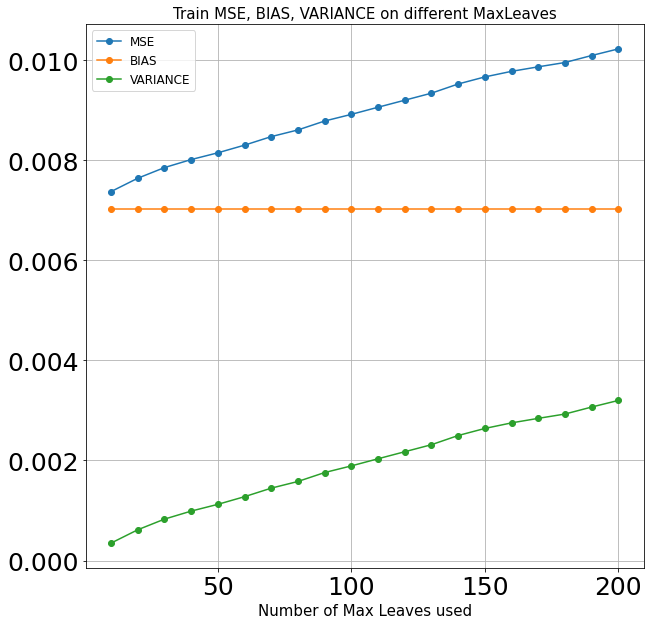

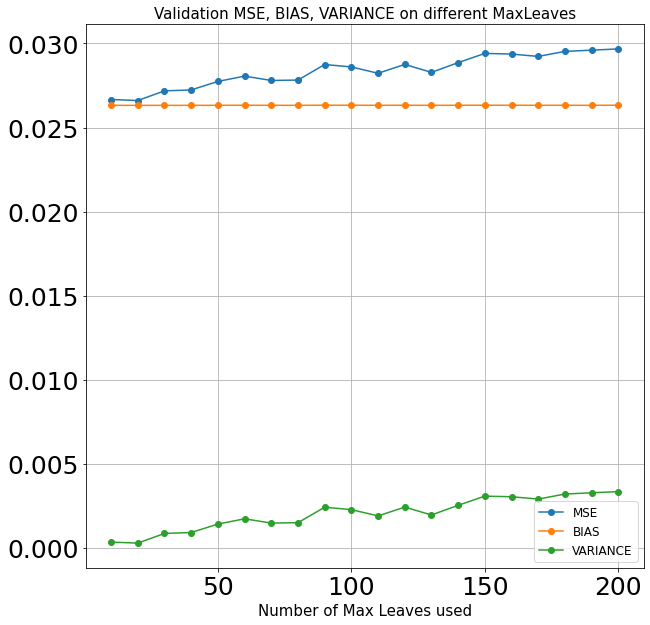

In [20]:
%%time
dt_model.append(
    get_dt(
        0,
        verbose   = False,
        debug     = False#,
        #file_name = 'prova0'
    )
)

Train: TUNING DEL MASSIMO NUMERO DI FOGLIE

Punteggio finale: 0.011768705830362136 (200) MaxLeaves
Best mse: 0.008058306142482038
Best number of MaxLeaves: 10

Punteggio finale: 0.007507800525323489 (200) MaxLeaves
Best bias: 0.007507800525323488
Best number of MaxLeaves: 10

Punteggio finale: 0.004260905305038671 (200) MaxLeaves
Best var: 0.0005505056171585546
Best number of MaxLeaves: 10

Validation: TUNING DEL MASSIMO NUMERO DI FOGLIE

Punteggio finale: 0.02899479388508032 (200) MaxLeaves
Best mse: 0.024540827510573793
Best number of MaxLeaves: 10

Punteggio finale: 0.023821192845515978 (200) MaxLeaves
Best bias: 0.023816692502516855
Best number of MaxLeaves: 180

Punteggio finale: 0.005173601039564315 (200) MaxLeaves
Best var: 0.000701967289624822
Best number of MaxLeaves: 10

Wall time: 11.3 s


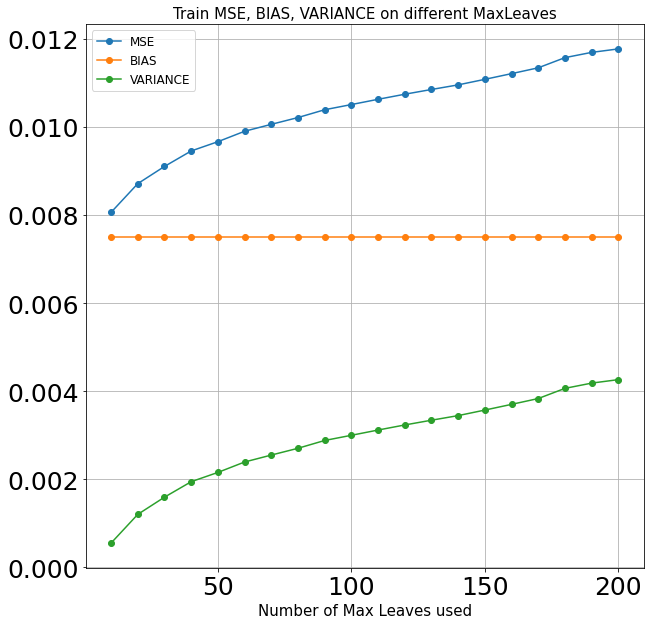

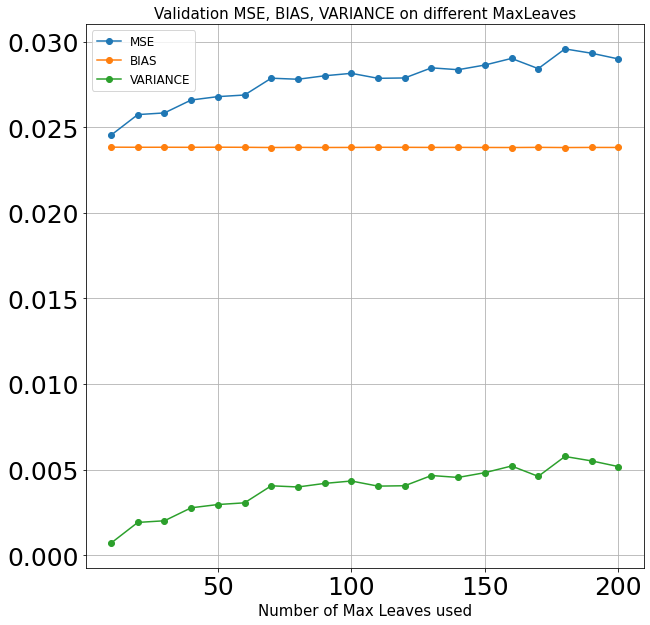

In [21]:
%%time
dt_model.append(
    get_dt(
        1,
        verbose   = False,
        debug     = False#,
        #file_name = 'prova1'
    )
)

Train: TUNING DEL MASSIMO NUMERO DI FOGLIE

Punteggio finale: 0.016391272799054057 (200) MaxLeaves
Best mse: 0.012195807622998019
Best number of MaxLeaves: 10

Punteggio finale: 0.011533919592977006 (200) MaxLeaves
Best bias: 0.011533919592977004
Best number of MaxLeaves: 10

Punteggio finale: 0.004857353206077033 (200) MaxLeaves
Best var: 0.0006618880300210031
Best number of MaxLeaves: 10

Validation: TUNING DEL MASSIMO NUMERO DI FOGLIE

Punteggio finale: 0.02972536858330145 (200) MaxLeaves
Best mse: 0.02547177399926454
Best number of MaxLeaves: 10

Punteggio finale: 0.024973557932718944 (200) MaxLeaves
Best bias: 0.024953926444242783
Best number of MaxLeaves: 70

Punteggio finale: 0.004751810650582522 (200) MaxLeaves
Best var: 0.0005066093295613852
Best number of MaxLeaves: 10

Wall time: 12.5 s


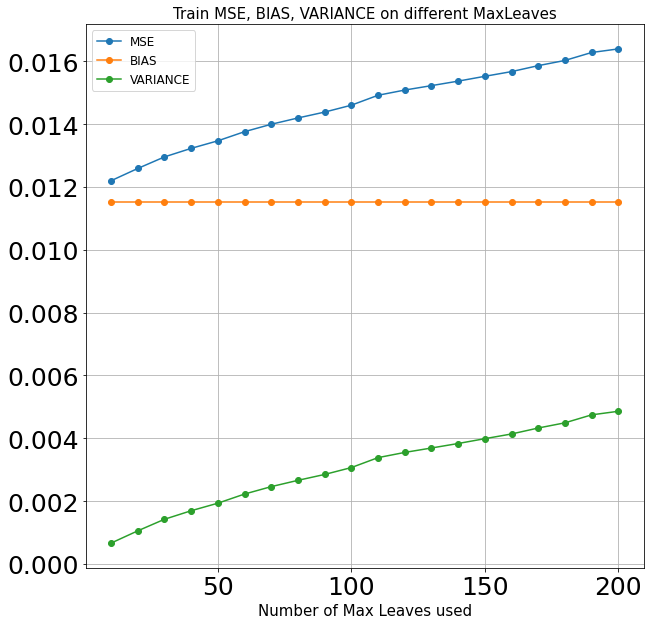

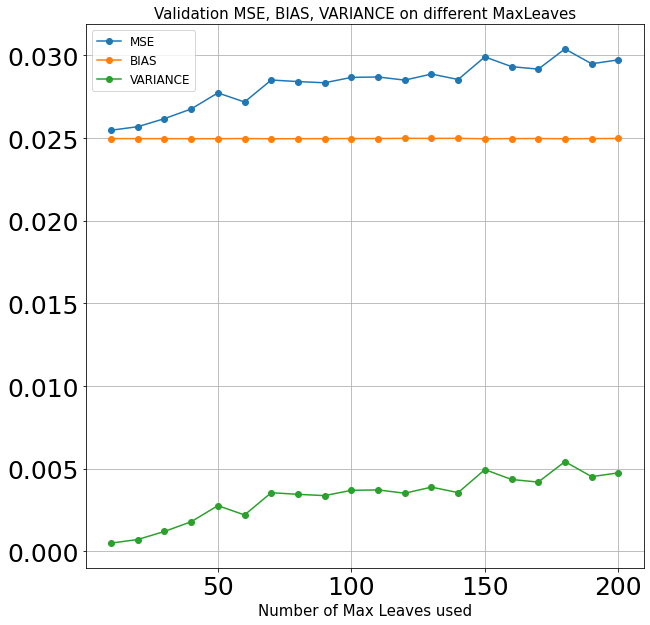

In [22]:
%%time
dt_model.append(
    get_dt(
        2,
        verbose   = False,
        debug     = False#,
        #file_name = 'prova2'
    )
)

In [23]:
dt_model

[DecisionTreeRegressor(max_leaf_nodes=20),
 DecisionTreeRegressor(max_leaf_nodes=10),
 DecisionTreeRegressor(max_leaf_nodes=10)]

In [24]:
def get_bias_var_mse(X, y, model):
        y_pred = model.predict(X)
        return {
            'bias': ((y - np.mean(y_pred))**2).mean(),\
            'var':  np.var(y_pred).mean(),\
            'mse':  ((y_pred - y.reshape(-1,1))**2).mean()
        }

In [25]:
def print_stats(X, y, models):
    for i in range(3):
        print(f'{region_names[i]}: {get_bias_var_mse(X[i], y[i].values.ravel(), models[i])}')
        print()

In [26]:
def print_all_stats(models):
    for X, y, name in zip(
        [X_train,        X_val, X_test],
        [y_train,        y_val, y_test],
        ['Train', 'Validation', 'Test']
    ):
        print(name)
        print()
        print_stats(X, y, models)
        print()
        

In [27]:
print_all_stats(dt_model)

Train

A: {'bias': 0.006929371419812538, 'var': 0.0005143121394468425, 'mse': 0.007443683559259259}

B: {'bias': 0.00753411100299893, 'var': 0.000300525654218031, 'mse': 0.007834636657216959}

C: {'bias': 0.01136004202899201, 'var': 0.0007063226665934561, 'mse': 0.012066364695585537}


Validation

A: {'bias': 0.027267868116667645, 'var': 0.00036001760862621775, 'mse': 0.02762788572529386}

B: {'bias': 0.019602214121277807, 'var': 0.0006985638249746259, 'mse': 0.020300777946252454}

C: {'bias': 0.02280530550173201, 'var': 0.0007471808734183047, 'mse': 0.02355248637515033}


Test

A: {'bias': 0.028634010534320183, 'var': 0.0007310389400899828, 'mse': 0.029365049474410137}

B: {'bias': 0.024116202683432147, 'var': 0.0007882261110446926, 'mse': 0.024904428794476827}

C: {'bias': 0.02847130865955196, 'var': 0.0005907157758008453, 'mse': 0.029062024435352822}




L'errore sembra provenire principalmente dal bias: uso il boosting per ridurlo 

# Boosting #

In [28]:
def boosting_train(X_train, y_train, X_val, y_val, baseModel, verbose=False, debug=False, file_name=''):
    
    def get_adaboost_regressor(Xs, ys, estimators):
        adaboost = AdaBoostRegressor(
            baseModel,
            n_estimators = estimators
        )
        adaboost.fit(Xs,ys)
        return adaboost
    
    def bias_var_mse(X, y, model):
        stats = get_bias_var_mse(X, y, model)
        return stats['bias'],\
               stats['var'],\
               stats['mse']
    
    def plot_mse(stats, name):
    
        print (f'{name}: TUNING DEL NUMERO DI STIMATORI')
        print()
    
        for n in ['mse', 'bias', 'var']:
        
            min_  = min(stats[n])
            best  = (np.argmin(stats[n]) * STEP) + START
            
            print (f'Punteggio finale: {stats[n][-1]} ({END}) stimatori')
            print (f'Best {n}:, {min_}')
            print (f'Best number of Estimators: {best}')
            print()

        fig, ax = plt.subplots(figsize=(len(stats['mse'])/2, 10))
        
        ax.tick_params(axis='both', which='major', labelsize=25)
        ax.tick_params(axis='both', which='minor', labelsize=15)
        
        ax.plot(range(START, END+1, STEP),  stats['mse' ], 'o-', label='MSE')
        ax.plot(range(START, END+1, STEP),  stats['bias'], 'o-', label='BIAS')
        ax.plot(range(START, END+1, STEP),  stats['var' ], 'o-', label='VARIANCE')
        
        ax.set_title(f'{name}: MSE, BIAS, VARIANCE on different Estimators', fontsize=15)
        ax.set_xlabel("Number of Max Estimators used", fontsize=15)
        ax.grid()
        ax.legend(prop={'size': 12})
        
        if file_name != '':
            fig.savefig('images/' + file_name + '_AdaBoostRegressor_' + name + '.jpg')
        
    

    START       = BOOST_START
    END         = BOOST_END
    STEP        = BOOST_STEP
    N_TESTS     = BOOST_NTEST
    SAMPLE_PERC = BOOST_SAMPLE_PERC
 

    stats   = np.array([])
    boosts  = range(START, END+1, STEP)
    
    y_train = y_train.values.ravel()
    y_val   = y_val  .values.ravel()
    
    first = True
    
    info = []
    
    train_stats = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    }

    val_stats = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    }
    
    for b in boosts:
        
        if debug:
            print(f'{b}/{END}')
            
        train_stats_s = {
            'bias' : [],\
            'var'  : [],\
            'mse'  : []
        }

        val_stats_s = {
            'bias' : [],\
            'var'  : [],\
            'mse'  : []
        } 
        
        
        # Resampling
        for i in range(N_TESTS):
            
            if debug:
                print(f'    {i+1}/{N_TESTS}')
            
            X_sample, y_sample = resample(X_train, y_train, n_samples = int(SAMPLE_PERC*len(y_train)))

            ada = get_adaboost_regressor(X_sample, y_sample, b)
            
            trn_bias, trn_var, trn_mse = bias_var_mse(X_train, y_train, ada)
            val_bias, val_var, val_mse = bias_var_mse(  X_val,   y_val, ada)

            train_stats_s['bias'].append(trn_bias)
            train_stats_s['var' ].append(trn_var )
            train_stats_s['mse' ].append(trn_mse )
            
            val_stats_s  ['bias'].append(val_bias)
            val_stats_s  ['var' ].append(val_var )
            val_stats_s  ['mse' ].append(val_mse )
            
            
        trn_bias_s = np.array(train_stats_s['bias']).mean()
        trn_var_s  = np.array(train_stats_s['var' ]).mean()
        trn_mse_s  = np.array(train_stats_s['mse' ]).mean()
        
        val_bias_s = np.array(  val_stats_s['bias']).mean()
        val_var_s  = np.array(  val_stats_s['var' ]).mean()
        val_mse_s  = np.array(  val_stats_s['mse' ]).mean()
        
            
        train_stats['bias'].append(trn_bias_s)
        train_stats['var' ].append(trn_var_s )
        train_stats['mse' ].append(trn_mse_s )
            
        val_stats  ['bias'].append(val_bias_s)
        val_stats  ['var' ].append(val_var_s )
        val_stats  ['mse' ].append(val_mse_s )
        
        
        info.append (
            f"\n(Train MSE:      {trn_mse_s } - Val MSE:      {val_mse_s })" +\
            f"\n(Train Bias:     {trn_bias_s} - Val Bias:     {val_bias_s})" +\
            f"\n(Train Variance: {trn_var_s } - Val Variance: {val_var_s })"
        )
        
        
        if(first or val_mse_s < best_mse):
            first = False
            best_mse = val_mse_s
            best_estimators = b
            
    if verbose:
        print(*info, sep='\n')
        
    plot_mse(train_stats, 'Train')
    plot_mse(val_stats, 'Validation') 
    
    return get_adaboost_regressor(X_train, y_train, best_estimators)

In [29]:
boost_model = []

In [30]:
def get_bmodel(index, verbose=False, debug=False, file_name=''):
    if file_name == '':
        file_name = region_ids[index]
    return boosting_train(
        X_train_sub [index],
        y_train_sub [index],
        X_val_sub   [index],
        y_val_sub   [index],
        dt_model[index],
        verbose   = verbose,
        debug     = debug,
        file_name = file_name
    )

Train: TUNING DEL NUMERO DI STIMATORI

Punteggio finale: 0.011253313536448473 (300) stimatori
Best mse:, 0.00837167469103742
Best number of Estimators: 20

Punteggio finale: 0.007495629745353767 (300) stimatori
Best bias:, 0.007116750969203027
Best number of Estimators: 20

Punteggio finale: 0.0037576837910947083 (300) stimatori
Best var:, 0.001254923721834395
Best number of Estimators: 20

Validation: TUNING DEL NUMERO DI STIMATORI

Punteggio finale: 0.03002700327020713 (300) stimatori
Best mse:, 0.027274849685085527
Best number of Estimators: 20

Punteggio finale: 0.026789978988622353 (300) stimatori
Best bias:, 0.02642405088676677
Best number of Estimators: 20

Punteggio finale: 0.0032370242815847688 (300) stimatori
Best var:, 0.0008507987983187588
Best number of Estimators: 20

Wall time: 19min 45s


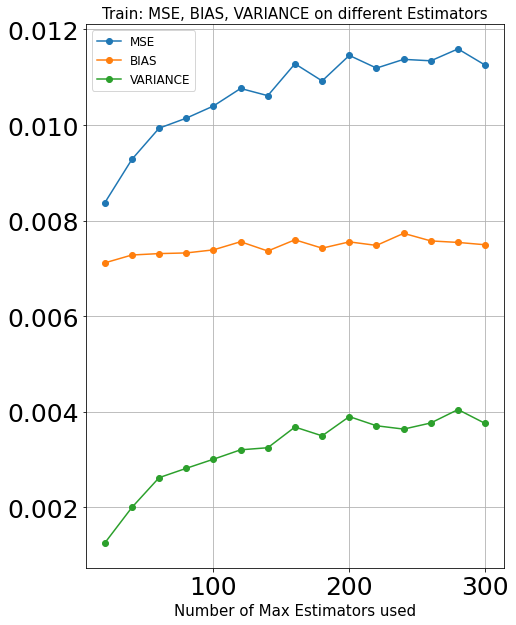

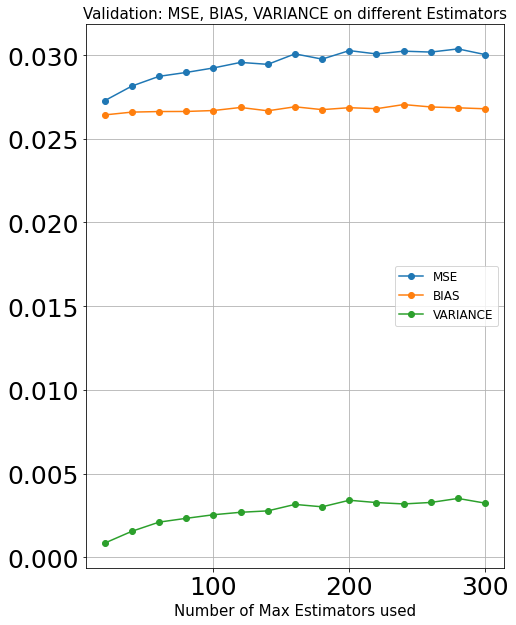

In [31]:
%%time
boost_model.append(
    get_bmodel(
        0,
        verbose   = False,
        debug     = False#,
        #file_name = 'Prova1'
    )   
)

Train: TUNING DEL NUMERO DI STIMATORI

Punteggio finale: 0.01475101974622022 (300) stimatori
Best mse:, 0.009242680348311038
Best number of Estimators: 20

Punteggio finale: 0.009706106524036523 (300) stimatori
Best bias:, 0.007871768332166445
Best number of Estimators: 20

Punteggio finale: 0.005044913222183688 (300) stimatori
Best var:, 0.001370912016144589
Best number of Estimators: 20

Validation: TUNING DEL NUMERO DI STIMATORI

Punteggio finale: 0.03003305051120881 (300) stimatori
Best mse:, 0.02506428784682253
Best number of Estimators: 20

Punteggio finale: 0.025359710316245766 (300) stimatori
Best bias:, 0.023971250255628206
Best number of Estimators: 20

Punteggio finale: 0.004673340194963061 (300) stimatori
Best var:, 0.0010930375911943357
Best number of Estimators: 20

Wall time: 13min 20s


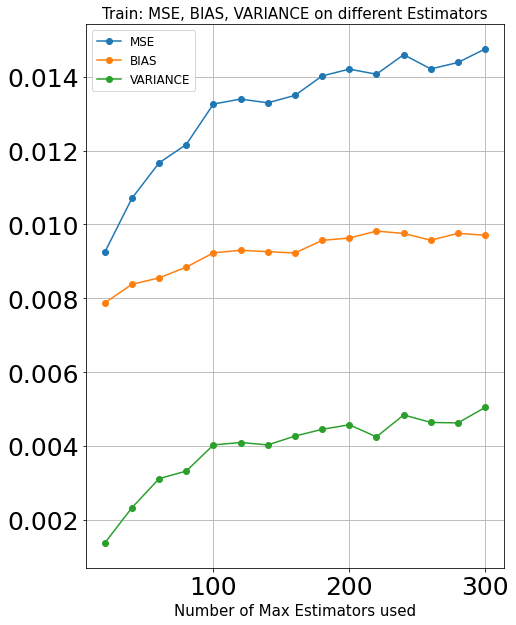

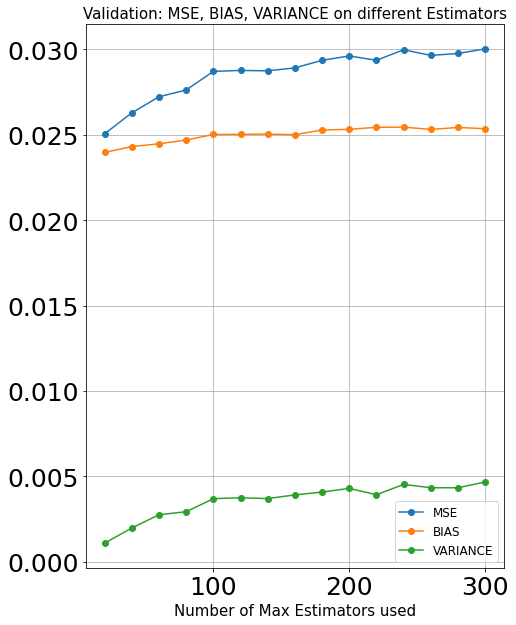

In [32]:
%%time
boost_model.append(
    get_bmodel(
        1,
        verbose   = False,
        debug     = False#,
        #file_name = 'Prova2'
    )    
)

Train: TUNING DEL NUMERO DI STIMATORI

Punteggio finale: 0.021318601703869053 (300) stimatori
Best mse:, 0.013366563499057025
Best number of Estimators: 20

Punteggio finale: 0.013426626441171315 (300) stimatori
Best bias:, 0.01208153884442736
Best number of Estimators: 20

Punteggio finale: 0.007891975262697748 (300) stimatori
Best var:, 0.0012850246546296617
Best number of Estimators: 20

Validation: TUNING DEL NUMERO DI STIMATORI

Punteggio finale: 0.03390844546135128 (300) stimatori
Best mse:, 0.02636273124625807
Best number of Estimators: 20

Punteggio finale: 0.026363226003838263 (300) stimatori
Best bias:, 0.025264940963078637
Best number of Estimators: 20

Punteggio finale: 0.007545219457513031 (300) stimatori
Best var:, 0.001097790283179449
Best number of Estimators: 20

Wall time: 17min 33s


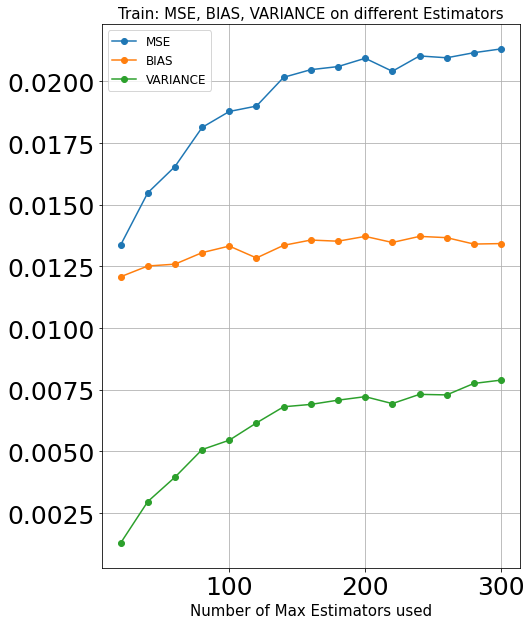

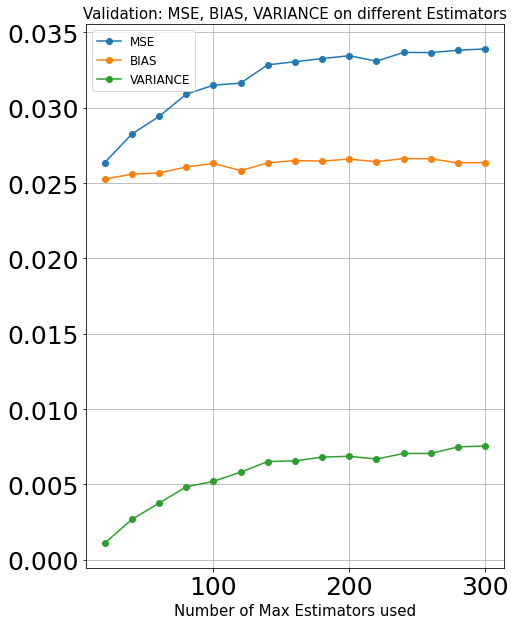

In [33]:
%%time
boost_model.append(
    get_bmodel(
        2,
        verbose   = False,
        debug     = False#,
        #file_name = 'Prova3'
    )
)

In [34]:
boost_model

[AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_leaf_nodes=20),
                   n_estimators=20),
 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_leaf_nodes=10),
                   n_estimators=20),
 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_leaf_nodes=10),
                   n_estimators=20)]

In [35]:
print_all_stats(boost_model)

Train

A: {'bias': 0.007270156247314693, 'var': 0.0011333685925849647, 'mse': 0.008403524839899666}

B: {'bias': 0.008052646762150067, 'var': 0.0009610319358240917, 'mse': 0.009013678697974157}

C: {'bias': 0.012523293133129783, 'var': 0.0009404237331872833, 'mse': 0.013463716866317034}


Validation

A: {'bias': 0.027559842060153113, 'var': 0.0009038055736949312, 'mse': 0.028463647633848108}

B: {'bias': 0.019987564828544444, 'var': 0.0009405911528907981, 'mse': 0.020928155981435242}

C: {'bias': 0.024046204880878403, 'var': 0.0008470060810660491, 'mse': 0.024893210961944447}


Test

A: {'bias': 0.028806017568080707, 'var': 0.0010948431640597533, 'mse': 0.02990086073214051}

B: {'bias': 0.024298847626875987, 'var': 0.0008589973853556741, 'mse': 0.025157845012231665}

C: {'bias': 0.02936763500695089, 'var': 0.0009280607804044824, 'mse': 0.030295695787355467}


